In [1]:
import os
print(f"Current directory of notebook: {os.path.realpath(os.path.curdir)}")
import sys
sys.path.append("../Python")
import ROOT as R
from array import array
import time
import numpy as np 
# Turn jsroot off if you want to make a pdf from this file.
%jsroot off
from root_helpers import SetStyle
from root_helpers import fancy_plot
from root_helpers import print_mc_particle_tree
from root_helpers import print_daughters
R.EnableImplicitMT()
recompile = True
try:
    if os.path.getmtime('../Python/Utility_Functions_C.so') - os.path.getmtime('../Python/Utility_Functions.C') > 0:
        recompile = False
        print("Recompile is not needed")
    else:
        print("Recompiling: ")
except:
    print("Recompile needed, file not found.")
if recompile:
    R.gROOT.LoadMacro("../Python/Utility_Functions.C++")
else:
    R.gSystem.Load("../Python/Utility_Functions_C.so")

r_result = R.gSystem.Load("../ECAL/build/lib/libEcal_Analysis")
if r_result != 0:
    print("Trouble loading the ECAL libray. Fix this!")
else:
    R.gInterpreter.ProcessLine('''auto EAC = Ecal_Analysis_Class();''')   # This is key. It puts the EAC in C++ space.
    print(f"ECAL Class version: {R.EAC.Version()}")
R.Utility_Functions()

Current directory of notebook: /System/Volumes/Data/data/HPS/Analysis/MC2021
Welcome to JupyROOT 6.29/01
Recompile is not needed
ECAL Class version: V1.0.9


'Utility Functions V1.0.6 \n'

In [2]:
Energies = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 3.742]
ch = R.TChain("MiniDST")
# for e in Energies:
#     ch.Add(f"/data/HPS/data/physrun2021/sim_2021/hpsForward_e\+_{e}GeV_z0.0_*_SLIC-v06-00-01_QGSP_BERT_HPS-v2019-3pt7GeV_recon.root")
# # ch.Add("/data/HPS/data/physrun2021/pass0/minidst/hps_0147*.root")
ch.Add("/data/HPS/data/MC/test/electrons_4_5GeV.000_recon.root")
# ch.Add("/data/HPS/data/MC/test/hpsForward_e-_3.742GeV_z0.0_0_SLIC-v06-00-01_QGSP_BERT_HPS-v2019-3pt7GeV_recon.root")
# ch.Add("/data/HPS/data/physrun2019/sim_2019/hpsForward_e-_4.5GeV_z-7.5_0_SLIC-v06-00-01_QGSP_BERT_HPS-PhysicsRun2019-v2-4pt5_recon.root")
print(f"Number of events loaded: {ch.GetEntries()/1e3:7.3f}k")
df = R.RDataFrame(ch)

Number of events loaded:   3.105k


In [3]:
dfx = R.EAC.extend_dataframe(R.RDF.AsRNode(df))
dfx = dfx.Define("mc_part_primary_energy","return mc_part_energy[mc_part_primary_index[0]]")  # This is sloppy. It assumes that there is always one and only one primary particle. Okay for this data.

In [4]:
print("Available data names in Tuple:")
ColumnNames=dfx.GetColumnNames()
ll = 0
pr_colnames = [x for x in ColumnNames if str(x).startswith('')]
for nn in pr_colnames:
    if ll < len(nn):
        ll = len(nn)
for n in range(len(pr_colnames)):
    if n%4 == 0:
        print("")
    print(f"{str(pr_colnames[n]):{ll}s}",end="")

Available data names in Tuple:

ecal_cluster_energy           ecal_cluster_hits             ecal_cluster_mc_id            ecal_cluster_mc_pdg           
ecal_cluster_mc_pdg_purity    ecal_cluster_nhits            ecal_cluster_seed_energy      ecal_cluster_seed_index       
ecal_cluster_seed_ix          ecal_cluster_seed_iy          ecal_cluster_time             ecal_cluster_uncor_energy     
ecal_cluster_uncor_hits       ecal_cluster_uncor_nhits      ecal_cluster_uncor_seed_energyecal_cluster_uncor_seed_index 
ecal_cluster_uncor_seed_ix    ecal_cluster_uncor_seed_iy    ecal_cluster_uncor_time       ecal_cluster_uncor_x          
ecal_cluster_uncor_y          ecal_cluster_uncor_z          ecal_cluster_x                ecal_cluster_y                
ecal_cluster_z                ecal_hit_energy               ecal_hit_index_x              ecal_hit_index_y              
ecal_hit_mc_contrib_ec        ecal_hit_mc_contrib_id        ecal_hit_mc_contrib_pdg       ecal_hit_mc_parent_id         


In [5]:
class Store:
    def __init__(self, name="", short_name="", data_frame=None):
        self.n = name
        self.sn = short_name
        self.df = data_frame



In [6]:
# Filter the dataframe
dfxc = dfx.Define("fiducial_cut","auto f=EAC.fiducial_cut(ecal_cluster_seed_ix,ecal_cluster_seed_iy); return f;")\
    .Filter("for(size_t i=0; i< fiducial_cut.size(); ++i) if( fiducial_cut[i] == 0){ return false;} return true;")
dfx1 = dfx.Filter("ecal_cluster_energy.size() == 1").Filter("mc_score_cluster_indexes.size()==1")
dfx1c =dfx1.Define("fiducial_cut","return EAC.fiducial_cut(ecal_cluster_seed_ix,ecal_cluster_seed_iy);")\
    .Filter("for(size_t i=0; i< fiducial_cut.size(); ++i) if( fiducial_cut[i] == false){ return false;} return true;")
df_store = [Store("No cuts","", dfx),
     Store("Ficucial cut","_fc",dfxc),
     Store("One Cluster", "_1c",dfx1 ),
     Store("One Cluster + Fiducial", "_fc_1c",dfx1c)]

In [7]:
max_i = 20
max_e = 3.9
for s in df_store:
    s.hh = s.df.Histo1D("mc_part_primary_index")
    s.hhn = s.df.Define("n","mc_score_primary_hits_e.size()").Histo1D(("hhn"+s.sn,"Num primary part.;N", max_i, -0.5,max_i - 0.5),"n")
    s.hhn2 = s.df.Define("n","mc_score_secondary_hits_e.size()").Histo1D(("hhn2"+s.sn,"Num secondary part.;N", max_i, -0.5,max_i - 0.5),"n")
    s.hhn_hits = s.df.Histo1D(("hhn_hits"+s.sn,"Number of hits per primary;N", max_i, -0.5,max_i - 0.5),"n_mc_score_primary_hits")
    s.hhn2_hits = s.df.Histo1D(("hhn2_hits"+s.sn,"Number of hits per secondary;N", max_i, -0.5,max_i - 0.5),"n_mc_score_secondary_hits")
    s.hhe = []
    s.hhe2 = []
    for e in Energies:
        s.hhe.append(s.df.Filter(f"abs(mc_part_primary_energy - {e})<0.1").Histo1D(("hhe"+s.sn,"Energy of Primary Hit on score plane.;E[GeV]",1000,-0.1,max_e),"mc_score_primary_hits_e"))
        s.hhe2.append(s.df.Filter(f"abs(mc_part_primary_energy - {e})<0.1").Histo1D(("hhe2"+s.sn,"Energy of Secondary Hit on score plane.;E[GeV]",1000,-0.1,max_e),"mc_score_secondary_hits_e"))
    s.hhn_clus = s.df.Define("n","return mc_score_cluster_indexes.size()").Histo1D(("hhn_clus"+s.sn,"N score clusters;N", max_i,  -0.5, max_i - 0.5),"n")
    s.hhn_clus_hits = s.df.Define("nn","RVec<int> out;for(size_t i=0; i< mc_score_cluster_indexes.size(); ++i){ out.push_back(mc_score_cluster_indexes[i].size());} return out;").Histo1D(("hhn_clus"+s.sn,"N score clusters;N", max_i,  -0.5, max_i - 0.5),"nn")
    s.hh_diff_x = s.df.Define("d","""RVec<double> out;
    for(size_t i=0; i< min(ecal_cluster_x.size(),mc_score_cluster_x.size()); ++i){
        out.push_back(ecal_cluster_x[i]-mc_score_cluster_x[i]);}
    return out;""").Histo1D(("hh_diff_x"+s.sn,"Ecal_x - Score_x;#Delta x [mm]",1000,-10.,10.),"d")
    s.hh_diff_y = s.df.Define("d","""RVec<double> out;
    for(size_t i=0; i< min(ecal_cluster_y.size(),mc_score_cluster_y.size()); ++i){
        out.push_back(ecal_cluster_y[i]-mc_score_cluster_y[i]);}
    return out;""").Histo1D(("hh_diff_y"+s.sn,"Ecal_y - Score_y;#Delta y [mm]",1000,-10.,10.),"d")
    s.hh_diff_e = s.df.Define("d","""RVec<double> out;
    for(size_t i=0; i< min(ecal_cluster_energy.size(),mc_score_cluster_e.size()); ++i){
        out.push_back(ecal_cluster_energy[i]-mc_score_cluster_e[i]);}
    return out;""").Histo1D(("hh_diff_e"+s.sn,"#Delta Ecal_e Score_e;#Delta E [GeV]",1000,-2.,1.),"d")
    s.hh_diff_e3 = s.df.Define("d","""RVec<double> out;
    for(size_t i=0; i< ecal_cluster_energy.size(); ++i){
        out.push_back(ecal_cluster_energy[i]- mc_part_primary_energy);}
    return out;""").Histo1D(("hh_diff_e3"+s.sn,"#Delta Ecal_e - MC Primary_e;#Delta E [GeV]",1000,-2.,1.),"d")
    s.hh_diff_xu = s.df.Define("d","""RVec<double> out;
    for(size_t i=0; i< min(ecal_cluster_uncor_x.size(),mc_score_cluster_x.size()); ++i){
        out.push_back(ecal_cluster_uncor_x[i]-mc_score_cluster_x[i]);}
    return out;""").Histo1D(("hh_diff_x"+s.sn,"Ecal_uncor_x - Score_x;#Delta x [mm]",1000,-10.,10.),"d")
    s.hh_diff_yu = s.df.Define("d","""RVec<double> out;
    for(size_t i=0; i< min(ecal_cluster_uncor_y.size(),mc_score_cluster_y.size()); ++i){
        out.push_back(ecal_cluster_uncor_y[i]-mc_score_cluster_y[i]);}
    return out;""").Histo1D(("hh_diff_y"+s.sn,"Ecal_uncor_y - Score_y;#Delta y [mm]",1000,-10.,10.),"d")
    s.hh_diff_eu = s.df.Define("d","""RVec<double> out;
    for(size_t i=0; i< min(ecal_cluster_uncor_energy.size(),mc_score_cluster_e.size()); ++i){
        out.push_back(ecal_cluster_uncor_energy[i]-mc_score_cluster_e[i]);}
    return out;""").Histo1D(("hh_diff_e"+s.sn,"Ecal_uncor_e - Score_e;#Delta E [GeV]",1000,-2.,1.),"d")
    s.hh_diff_e3u = s.df.Define("d","""RVec<double> out;
    for(size_t i=0; i< ecal_cluster_uncor_energy.size(); ++i){
        out.push_back(ecal_cluster_uncor_energy[i]- mc_part_primary_energy);}
    return out;""").Histo1D(("hh_diff_e3"+s.sn,"Ecal_uncor_e - MC Primary_e;#Delta E [GeV]",1000,-2.,1.),"d")

CPU times: user 2.69 s, sys: 108 ms, total: 2.8 s
Wall time: 2.83 s


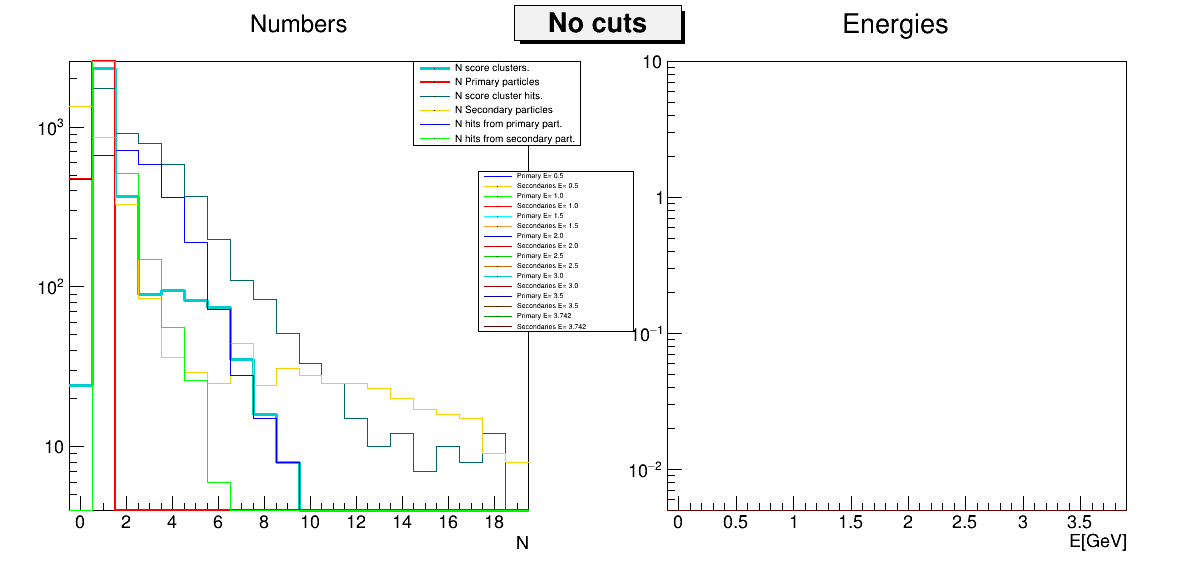

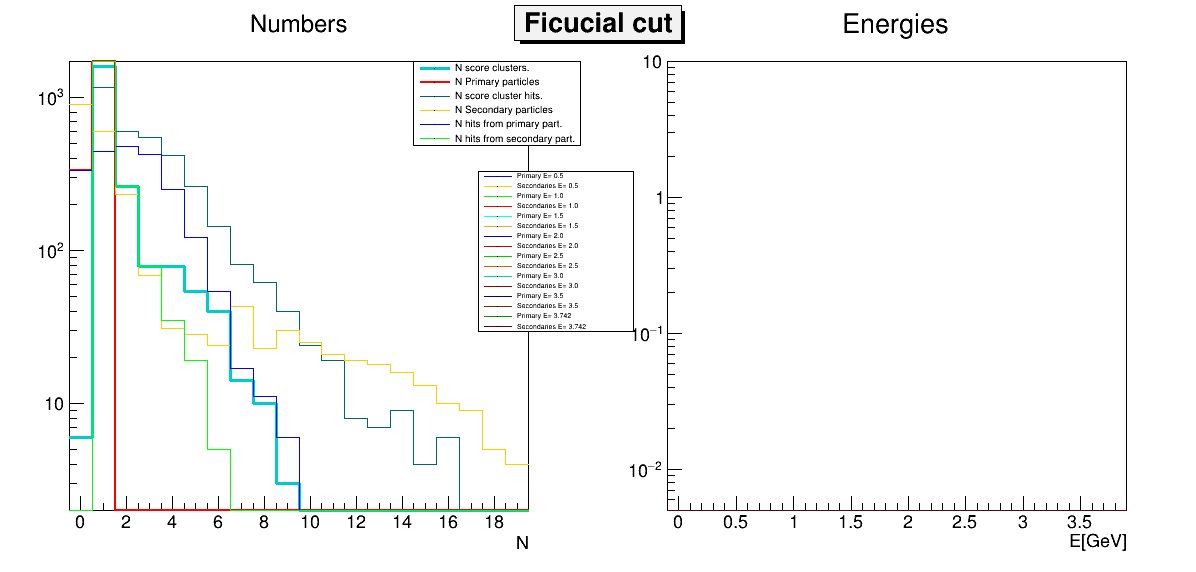

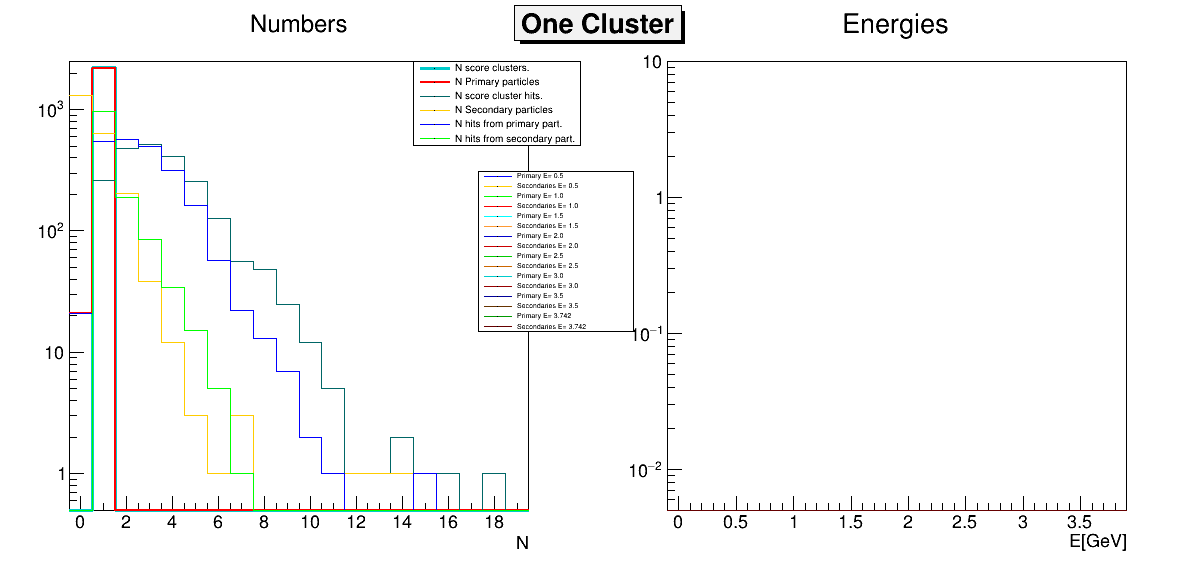

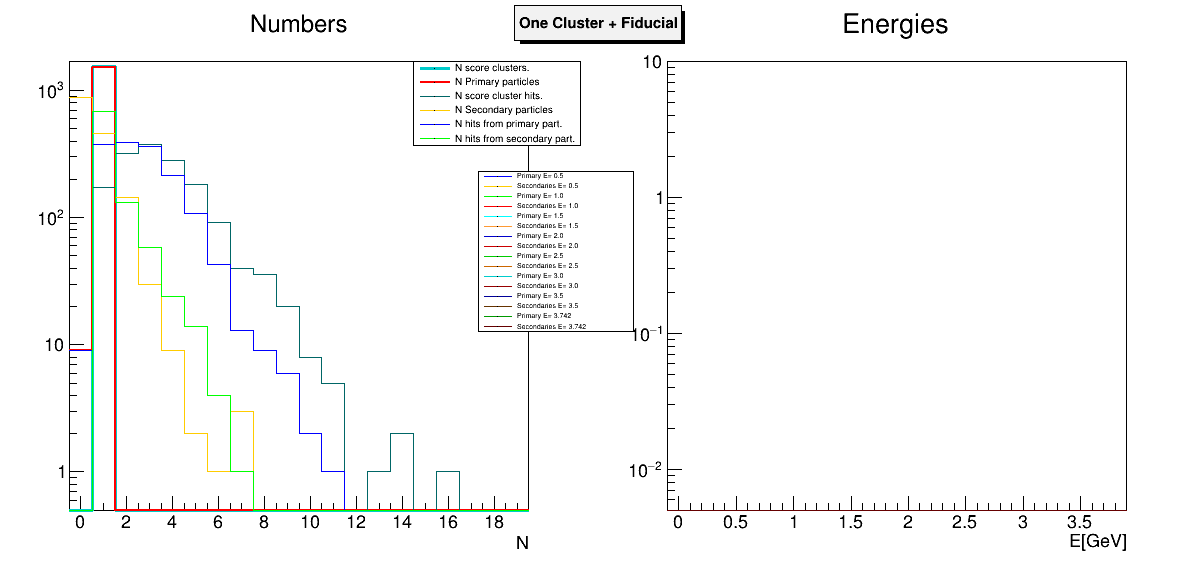

In [8]:
%%time
hist_colors = [R.kBlue, R.kGreen, R.kCyan, R.kBlue+1, R.kGreen+1, R.kCyan+1, R.kBlue+2, R.kGreen+2, R.kCyan+2]
hist_colors2 = [R.kOrange, R.kRed, R.kOrange+1, R.kRed+1, R.kOrange+2, R.kRed+2, R.kOrange+3, R.kRed+3]
for s  in df_store:
    s.cc0 = R.TCanvas("cc0"+s.sn,"CC0",1200,600)
    s.cc0.Divide(2,0)
    p1 = s.cc0.cd(1)
    s.leg0_p1 = R.TLegend(0.70, 0.75 ,0.99, 0.9)
    p1.SetLogy()
    s.hhn.SetStats(0)
    s.hhn2.SetStats(0)
    s.hhn2.SetTitle("Numbers")
    s.hhn2.Draw()

    s.hhn_clus.SetLineWidth(3)
    s.hhn_clus.SetLineColor(R.kCyan+1)
    s.hhn_clus.Draw("same")
    s.leg0_p1.AddEntry(s.hhn_clus.GetPtr(),"N score clusters.")

    s.hhn.SetLineWidth(2)
    s.hhn.SetLineColor(R.kRed)
    s.hhn.Draw("same")
    s.leg0_p1.AddEntry(s.hhn.GetPtr(),"N Primary particles")

    s.hhn_clus_hits.SetLineColor(R.kCyan+3)
    s.hhn_clus_hits.Draw("same")
    s.leg0_p1.AddEntry(s.hhn_clus_hits.GetPtr(),"N score cluster hits.")

    s.hhn2.SetLineColor(R.kOrange)
    s.hhn2.SetStats(0)
    s.hhn2.Draw("same")
    s.leg0_p1.AddEntry(s.hhn2.GetPtr(),"N Secondary particles")
    s.hhn_hits.SetLineColor(R.kBlue)
    s.hhn_hits.Draw("same")
    s.leg0_p1.AddEntry(s.hhn_hits.GetPtr(),"N hits from primary part.")
    s.hhn2_hits.SetLineColor(R.kGreen)
    s.hhn2_hits.Draw("same")
    s.leg0_p1.AddEntry(s.hhn2_hits.GetPtr(),"N hits from secondary part.")
    s.leg0_p1.Draw()
    p2 = s.cc0.cd(2)
    p2.SetLogy()
    s.leg0_p2 = R.TLegend(0.40, 0.42 ,0.53, 0.7)
    max_y=0
    for i in range(len(Energies)):
        if s.hhe[i].GetMaximum() > max_y:
            max_y = s.hhe[i].GetMaximum()
        if s.hhe2[i].GetMaximum() > max_y:
            max_y = s.hhe2[i].GetMaximum()

    for i in range(len(Energies)):
        if i == 0:
            s.hhe[i].SetTitle(f"Energies")
            s.hhe[i].SetStats(0)
            s.hhe[i].SetMaximum(max_y)
        s.hhe[i].SetLineColor(hist_colors[i])
        s.hhe[i].Draw("same")
        s.leg0_p2.AddEntry(s.hhe[i].GetPtr(), f"Primary E= {Energies[i]}")
        s.hhe2[i].SetStats(0)
        s.hhe2[i].SetLineColor(hist_colors2[i])
        s.hhe2[i].Draw("same")
        s.leg0_p2.AddEntry(s.hhe2[i].GetPtr(), f"Secondaries E= {Energies[i]}")

    s.cc0.cd()
    s.leg0_p2.Draw()
    s.cc0.cd()
    s.cc0_text = R.TPaveText(0.43,0.93,0.57,0.99)
    s.cc0_text.AddText(f"{s.n}")
    s.cc0_text.Draw()

    s.cc0.Draw()

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 2.86 µs


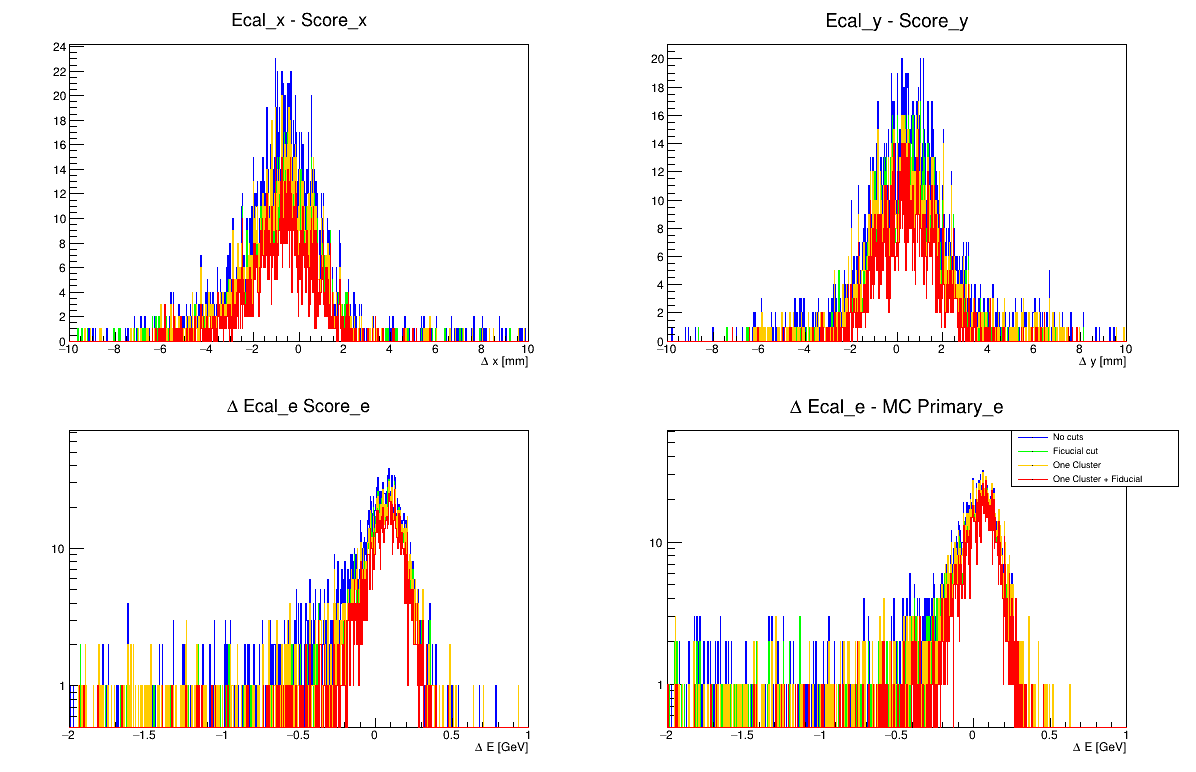

In [9]:
%time
hist_colors = [R.kBlue, R.kGreen, R.kOrange, R.kRed, R.kCyan]
cc1 = R.TCanvas("cc1","CC1",1200,800)
cc1.Divide(2,2)
cc1.cd(1)
leg1 = R.TLegend(0.7,0.75, 0.99, 0.9)
for i in range(len(df_store)):
    s = df_store[i]
    p1 = cc1.cd(1)
    s.hh_diff_x.SetStats(0)
    s.hh_diff_x.SetLineColor(hist_colors[i])
    s.hh_diff_x.Draw("same")
    leg1.AddEntry(s.hh_diff_x.GetPtr(), f"{s.n}")
    p2 = cc1.cd(2)
    s.hh_diff_y.SetStats(0)
    s.hh_diff_y.SetLineColor(hist_colors[i])
    s.hh_diff_y.Draw("same")
    p3 = cc1.cd(3)
    p3.SetLogy()
    s.hh_diff_e.SetStats(0)
    s.hh_diff_e.SetLineColor(hist_colors[i])
    s.hh_diff_e.Draw("same")

    p4 = cc1.cd(4)
    p4.SetLogy()
    s.hh_diff_e3.SetStats(0)
    s.hh_diff_e3.SetLineColor(hist_colors[i])
    s.hh_diff_e3.Draw("same")

cc1.cd(4)
leg1.Draw()
cc1.Draw()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 2.86 µs


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc1


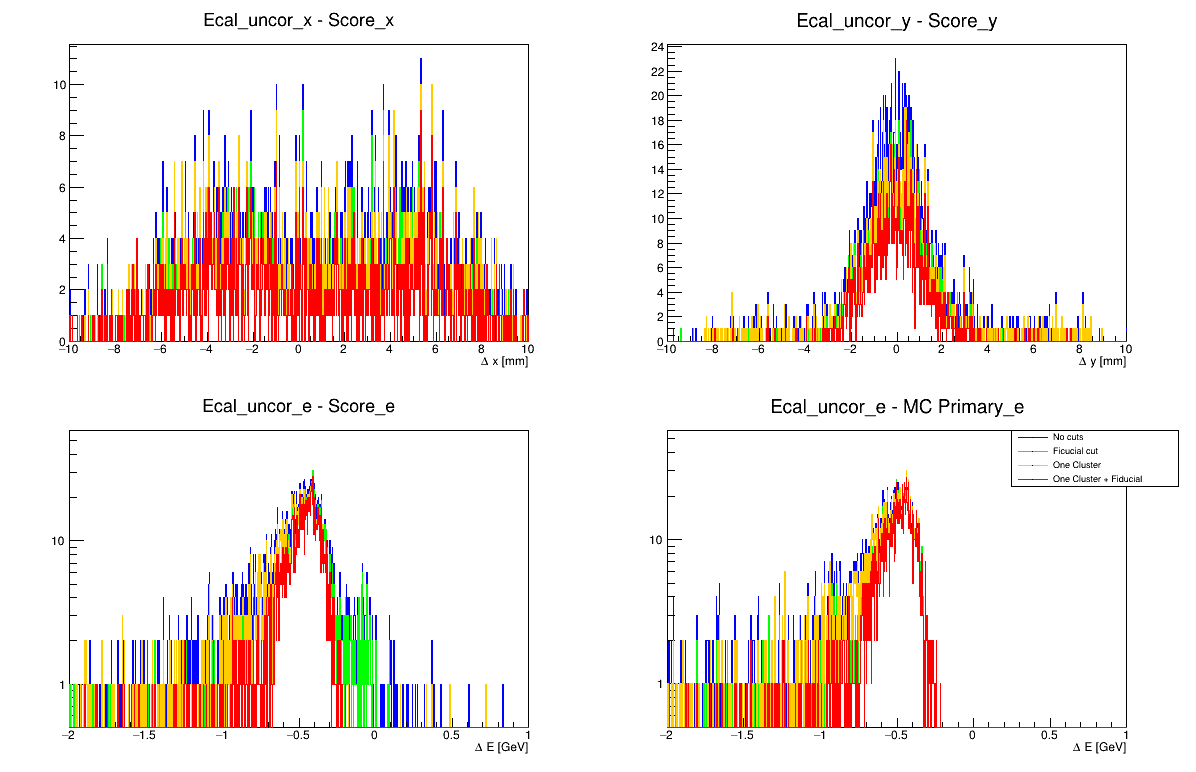

In [10]:
%time
cc2 = R.TCanvas("cc1","CC1",1200,800)
cc2.Divide(2,2)
cc2.cd(1)
leg2 = R.TLegend(0.7,0.75, 0.99, 0.9)
for i in range(len(df_store)):
    s = df_store[i]
    p1 = cc2.cd(1)
    s.hh_diff_xu.SetStats(0)
    s.hh_diff_xu.SetLineColor(hist_colors[i])
    s.hh_diff_xu.Draw("same")
    leg2.AddEntry(s.hh_diff_xu.GetPtr(), f"{s.n}")
    p2 = cc2.cd(2)
    s.hh_diff_yu.SetStats(0)
    s.hh_diff_yu.SetLineColor(hist_colors[i])
    s.hh_diff_yu.Draw("same")
    p3 = cc2.cd(3)
    p3.SetLogy()
    s.hh_diff_eu.SetStats(0)
    s.hh_diff_eu.SetLineColor(hist_colors[i])
    s.hh_diff_eu.Draw("same")

    p4 = cc2.cd(4)
    p4.SetLogy()
    s.hh_diff_e3u.SetStats(0)
    s.hh_diff_e3u.SetLineColor(hist_colors[i])
    s.hh_diff_e3u.Draw("same")

cc2.cd(4)
leg2.Draw()
cc2.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc1
